In [1]:
%set_env OMP_NUM_THREADS=1

env: OMP_NUM_THREADS=1


In [34]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus
import dedalus.public as d3
import logging
import h5py
logger = logging.getLogger(__name__)
logging.getLogger('subsystems').setLevel('ERROR')

# Incompressible Stokes equation on topological cylinder

Initial time = 5


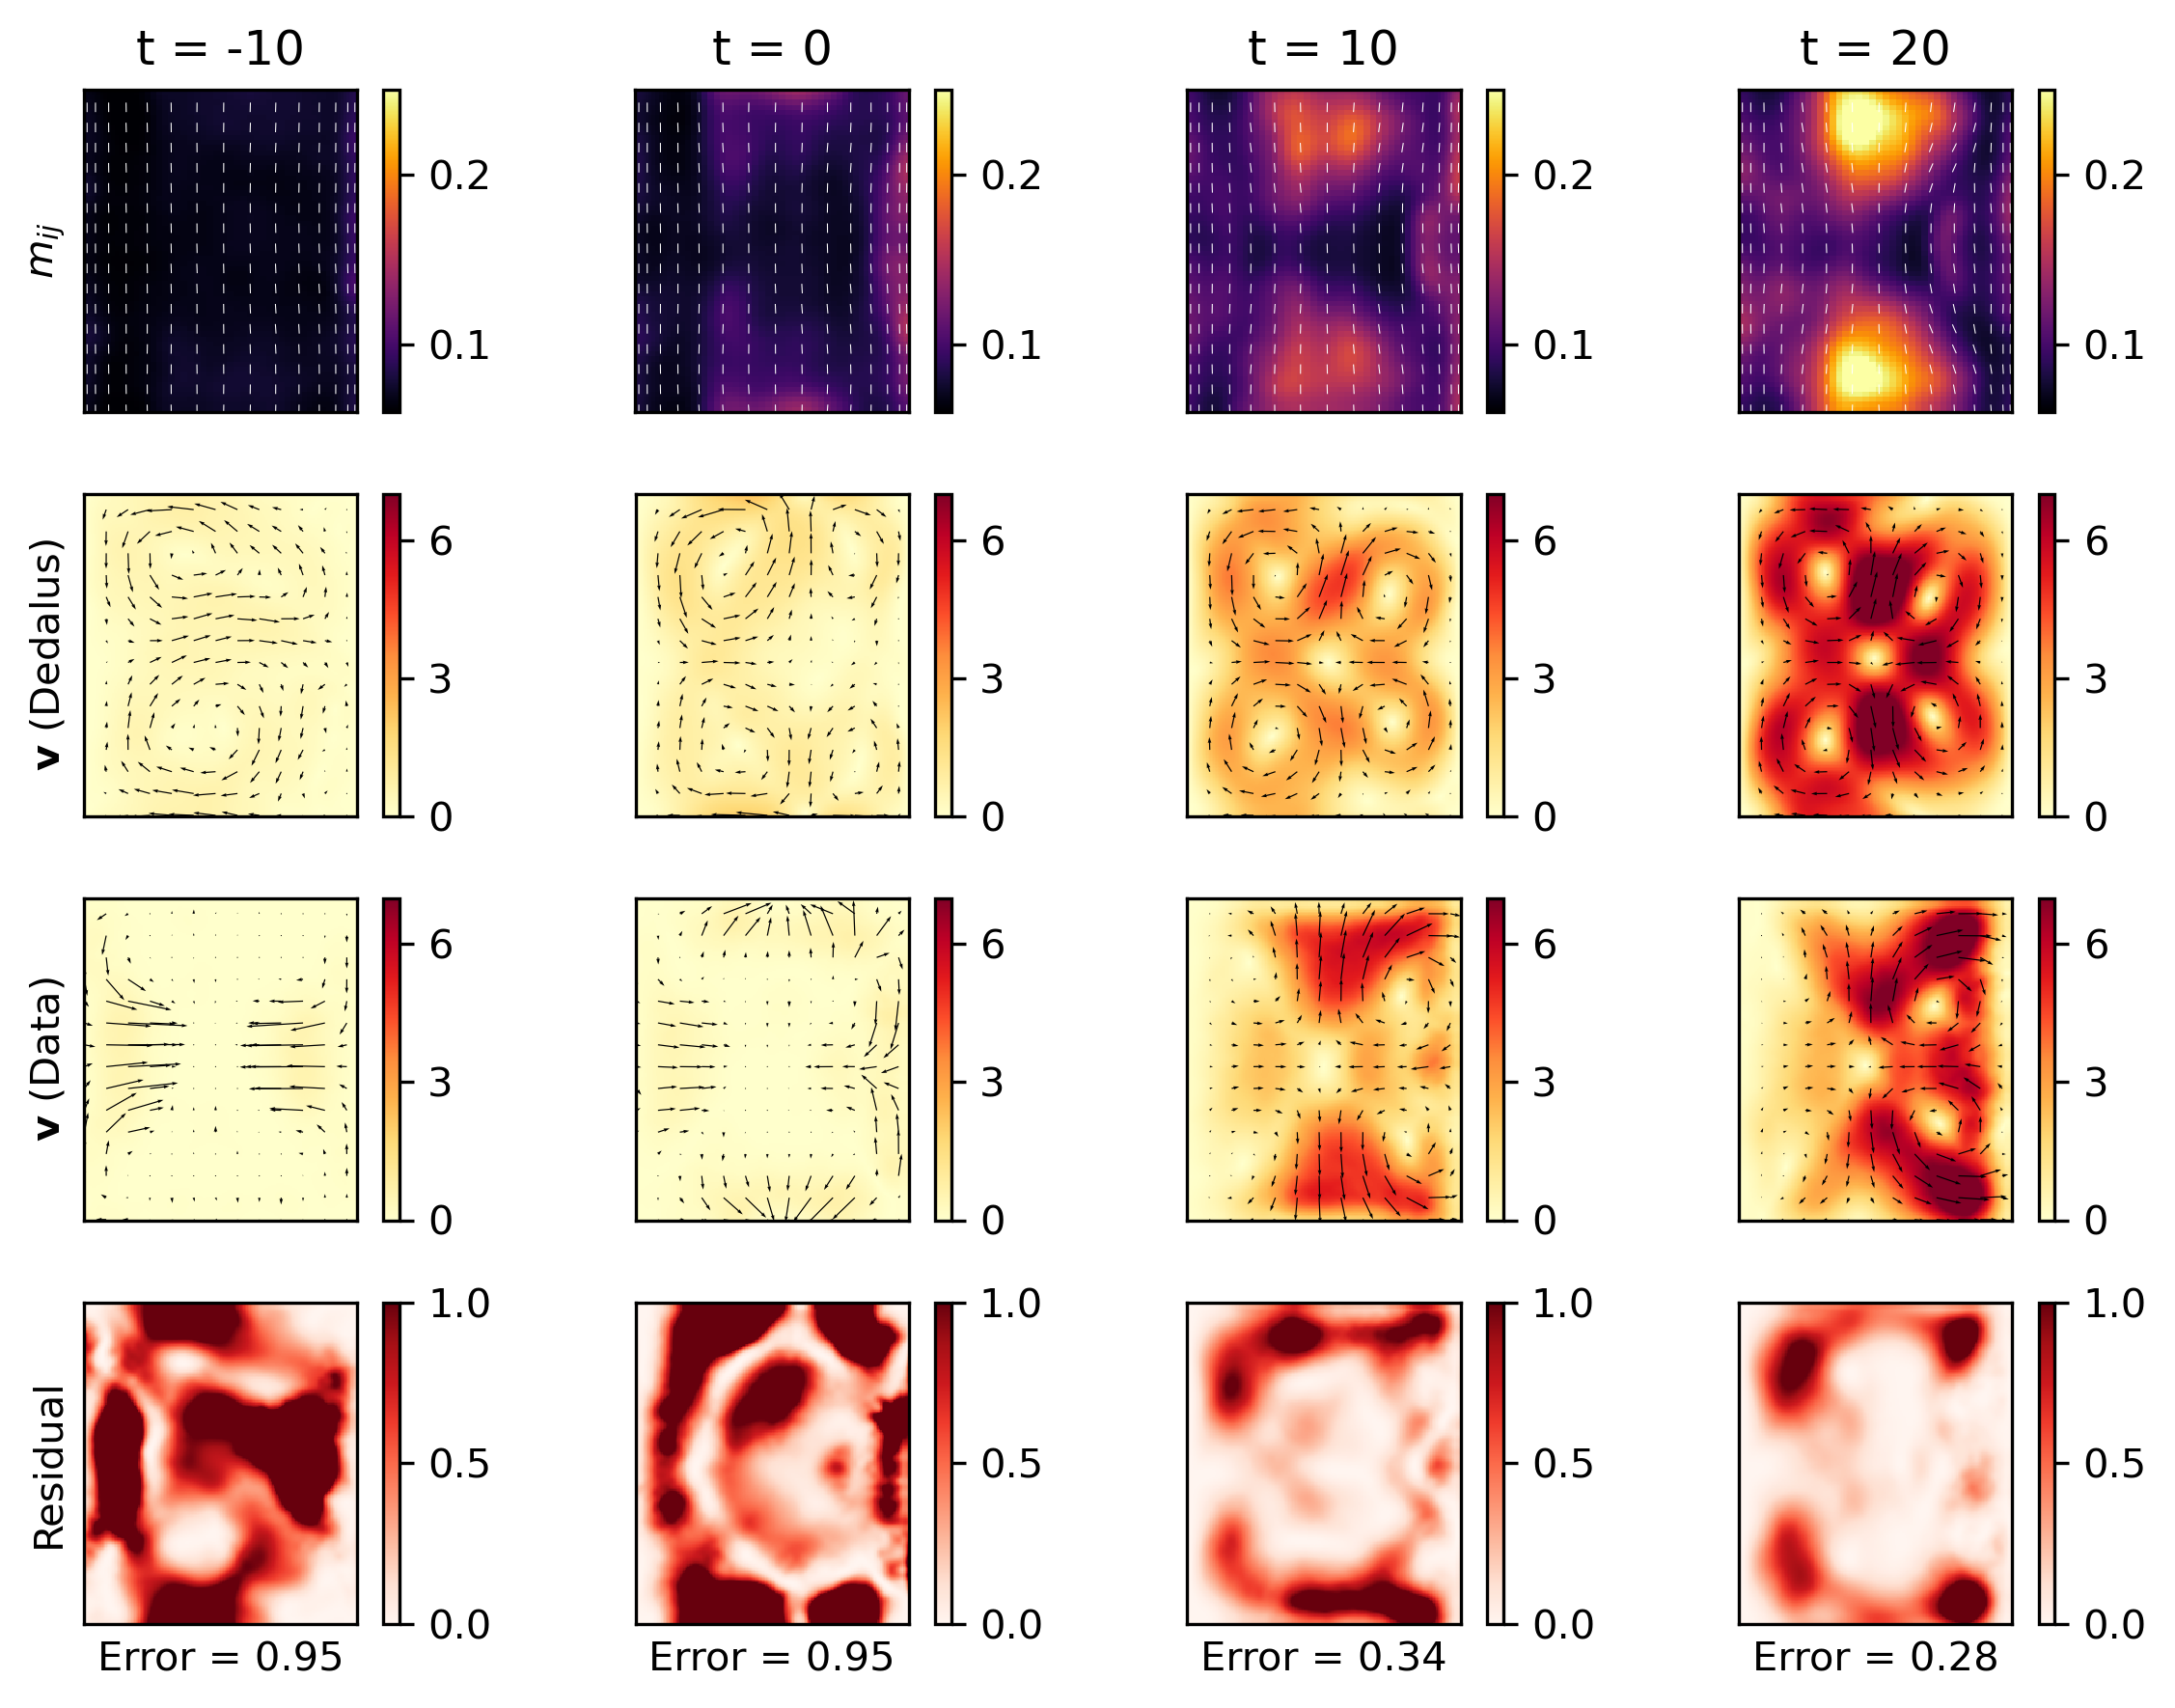

In [109]:
from scipy.interpolate import RectBivariateSpline
folder = '../flydrive/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP/ensemble'
tt = 15
t0 = np.load(f'{folder}/t.npy')
print(f'Initial time = {t0[tt]}')
m0 = np.load(f'{folder}/tensor2D.npy', mmap_mode='r')
v0 = np.load(f'{folder}/velocity2D.npy', mmap_mode='r')

Lx, Ly = 452., 533.
Nx, Ny = 64, 64

dealias = 3/2
mu, α = 1, 8

# Bases
coords = d3.CartesianCoordinates("x", "y")
dist = d3.Distributor(coords, dtype=np.float64)
xbasis = d3.Chebyshev(  coords["x"], size=Nx, bounds=(-Lx/2,Lx/2), dealias=dealias)
ybasis = d3.RealFourier(coords["y"], size=Ny, bounds=(-Ly/2,Ly/2), dealias=dealias)
x1, y1 = dist.local_grids(xbasis, ybasis)
x0 = np.linspace(-Lx/2, Lx/2, m0.shape[-1])
y0 = np.linspace(-Ly/2, Ly/2, m0.shape[-2])
x = np.squeeze(xbasis.local_grid(dist, 1))
y = np.squeeze(ybasis.local_grid(dist, 1))

skip = 4
X, Y = np.meshgrid(x.flatten()[::skip], y.flatten()[::skip])
X0, Y0 = np.meshgrid(x0.flatten()[::16], y0.flatten()[::16])


def get_g_with_scales(field, scales):
    f = field.copy()
    f.change_scales(scales)
    return f["g"]

def residual(u, v):
    '''
    We assume u is the INPUT and v is the TARGET
    Using residual metric from Sebastian's eLife paper to track how flow configuration is predicted
    '''
    umag = np.linalg.norm(u, axis=-3)
    vmag = np.linalg.norm(v, axis=-3)

    uavg = np.sqrt(np.mean(umag**2, axis=(-2,-1), keepdims=True))
    vavg = np.sqrt(np.mean(vmag**2, axis=(-2,-1), keepdims=True))

    res = uavg**2 * vmag**2 + vavg**2 * umag**2 - 2 * uavg * vavg * np.einsum('...ijk,...ijk->...jk', u, v)
    denom = 2 * vavg**2 * uavg**2
    denom[denom == 0] += 1
    res /= denom
    return res

times = [0, 10, 20, 30]
fig, ax = plt.subplots(4, len(times), dpi=300, figsize=(len(times)*2, 6))

for i, tt in enumerate([0, 10, 20, 30]):
    # Fields
    v = dist.VectorField(coords, name="v", bases=(xbasis,ybasis))
    m = dist.TensorField(coords, name="m", bases=(xbasis,ybasis))
    p = dist.ScalarField(name='p', bases=(xbasis,ybasis))

    #Tau terms
    tau_p  = dist.Field(name='tau_p')  #Residual for pressure
    tau_vy = dist.Field(name='tau_v') #Residual for y-component of velocity
    tau_v1 = dist.VectorField(coords, name='tau_v1', bases=ybasis)
    tau_v2 = dist.VectorField(coords, name='tau_v2', bases=ybasis)

    # Forcing conditions
    m["g"][0,0,:,:] = RectBivariateSpline(x0, y0, m0[tt, 1,1].T)(x, y)
    m["g"][0,1,:,:] = RectBivariateSpline(x0, y0, m0[tt, 0,1].T)(x, y)
    m["g"][1,0,:,:] = m['g'][0,1,:,:]
    m["g"][1, 1,:,:] = RectBivariateSpline(x0, y0, m0[tt, 0, 0].T)(x, y)

    #Substitutions
    ex, ey = coords.unit_vector_fields(dist)
    lift_basis = xbasis.derivative_basis(1)
    lift = lambda A: d3.Lift(A, lift_basis, -1)
    grad_v = d3.grad(v) - ex*lift(tau_v1)

    #Static velocity Problem
    problem = d3.LBVP([v, p, tau_p, tau_vy, tau_v1, tau_v2], namespace=locals())
    problem.add_equation("mu*div(grad_v) - grad(p) + lift(tau_v2) + tau_vy*ey = -α * div(m) ") # Stokes equation (with tau residual)
    problem.add_equation("trace(grad_v) + tau_p = 0")  #Incompressibility (with tau residual)

    #Boundary conditions
    problem.add_equation("v(x=-Lx/2) = 0") #Dirichlet BC 
    problem.add_equation("v(x=+Lx/2) = 0") #Dirichlet BC
    problem.add_equation("integ(p) = 0")        #Zero-mean pressure gauge
    problem.add_equation("integ(v @ ey) = 0")   #No net y-flow gauge

    # Solver
    solver = problem.build_solver()
    solver.solve()

    # Extract fields
    vi = get_g_with_scales(v, (1, 1))
    mij = get_g_with_scales(m, (1, 1))

    v1 = np.zeros([2, 236, 200])
    m1 = np.zeros([2, 2, 236, 200])

    v1[1] = RectBivariateSpline(x, y, vi[0])(x0, y0).T
    v1[0] = RectBivariateSpline(x, y, vi[1])(x0, y0).T

    # Plot fields
    mij = mij.transpose(2, 3, 0, 1)
    m = np.linalg.norm(mij, axis=(2, 3))
    el, ev = np.linalg.eigh(mij) #Positive eigenvalue is n
    n = ev[..., 1]

    pcM = ax[0, i].pcolormesh(x, y, m.T, cmap='inferno', vmin=0.06, vmax=0.25)
    ax[0, i].quiver(X, Y, n[::skip, ::skip, 0].T, n[::skip, ::skip, 1].T,
                pivot='middle', color='white',
                headwidth=0, headlength=0, headaxislength=0)

    cb = plt.colorbar(pcM, ax=ax[0,i], ticks=[0.1, 0.2])
  
    pcV = ax[1,i].pcolormesh(x0, y0, np.linalg.norm(v1, axis=0), vmin=0, vmax=7, cmap='YlOrRd')
    ax[1,i].quiver(X0, Y0, v1[1, ::16, ::16], v1[0, ::16, ::16], 
                   color="black")
    cb = plt.colorbar(pcV, ax=ax[1,i], ticks=[0, 3, 6])


    pcV = ax[2,i].pcolormesh(x0, y0, np.linalg.norm(v0[tt], axis=0), vmin=0, vmax=7, cmap='YlOrRd')
    ax[2,i].quiver(X0, Y0, v0[tt, 1, ::16, ::16], v0[tt, 0, ::16, ::16], 
                   color="black")
    cb = plt.colorbar(pcV, ax=ax[2,i], ticks=[0, 3, 6])

    res = residual(v0[tt], v1)
    pcR = ax[3,i].pcolormesh(x0, y0, res, cmap='Reds', vmin=0, vmax=1)
    cb = plt.colorbar(pcR, ax=ax[3,i], ticks=[0, 0.5, 1])
    ax[3, i].set_xlabel(f'Error = {res.mean():.2f}')

    ax[0, i].set_title(f't = {t0[tt]}')

ax[0, 0].set_ylabel(r'$m_{ij}$')
ax[1, 0].set_ylabel(r'$\mathbf{v}$ (Dedalus)')
ax[2, 0].set_ylabel(r'$\mathbf{v}$ (Data)')
ax[3, 0].set_ylabel('Residual')

for a in ax.flatten():
    a.set(aspect='equal', xticks=[], yticks=[])

plt.tight_layout()

# Compressible Stokes flow on a topological torus

Initial time = 5
3.0590222692694624e-05
0.6692850924284812
99.33071490757152
99.99996940977731


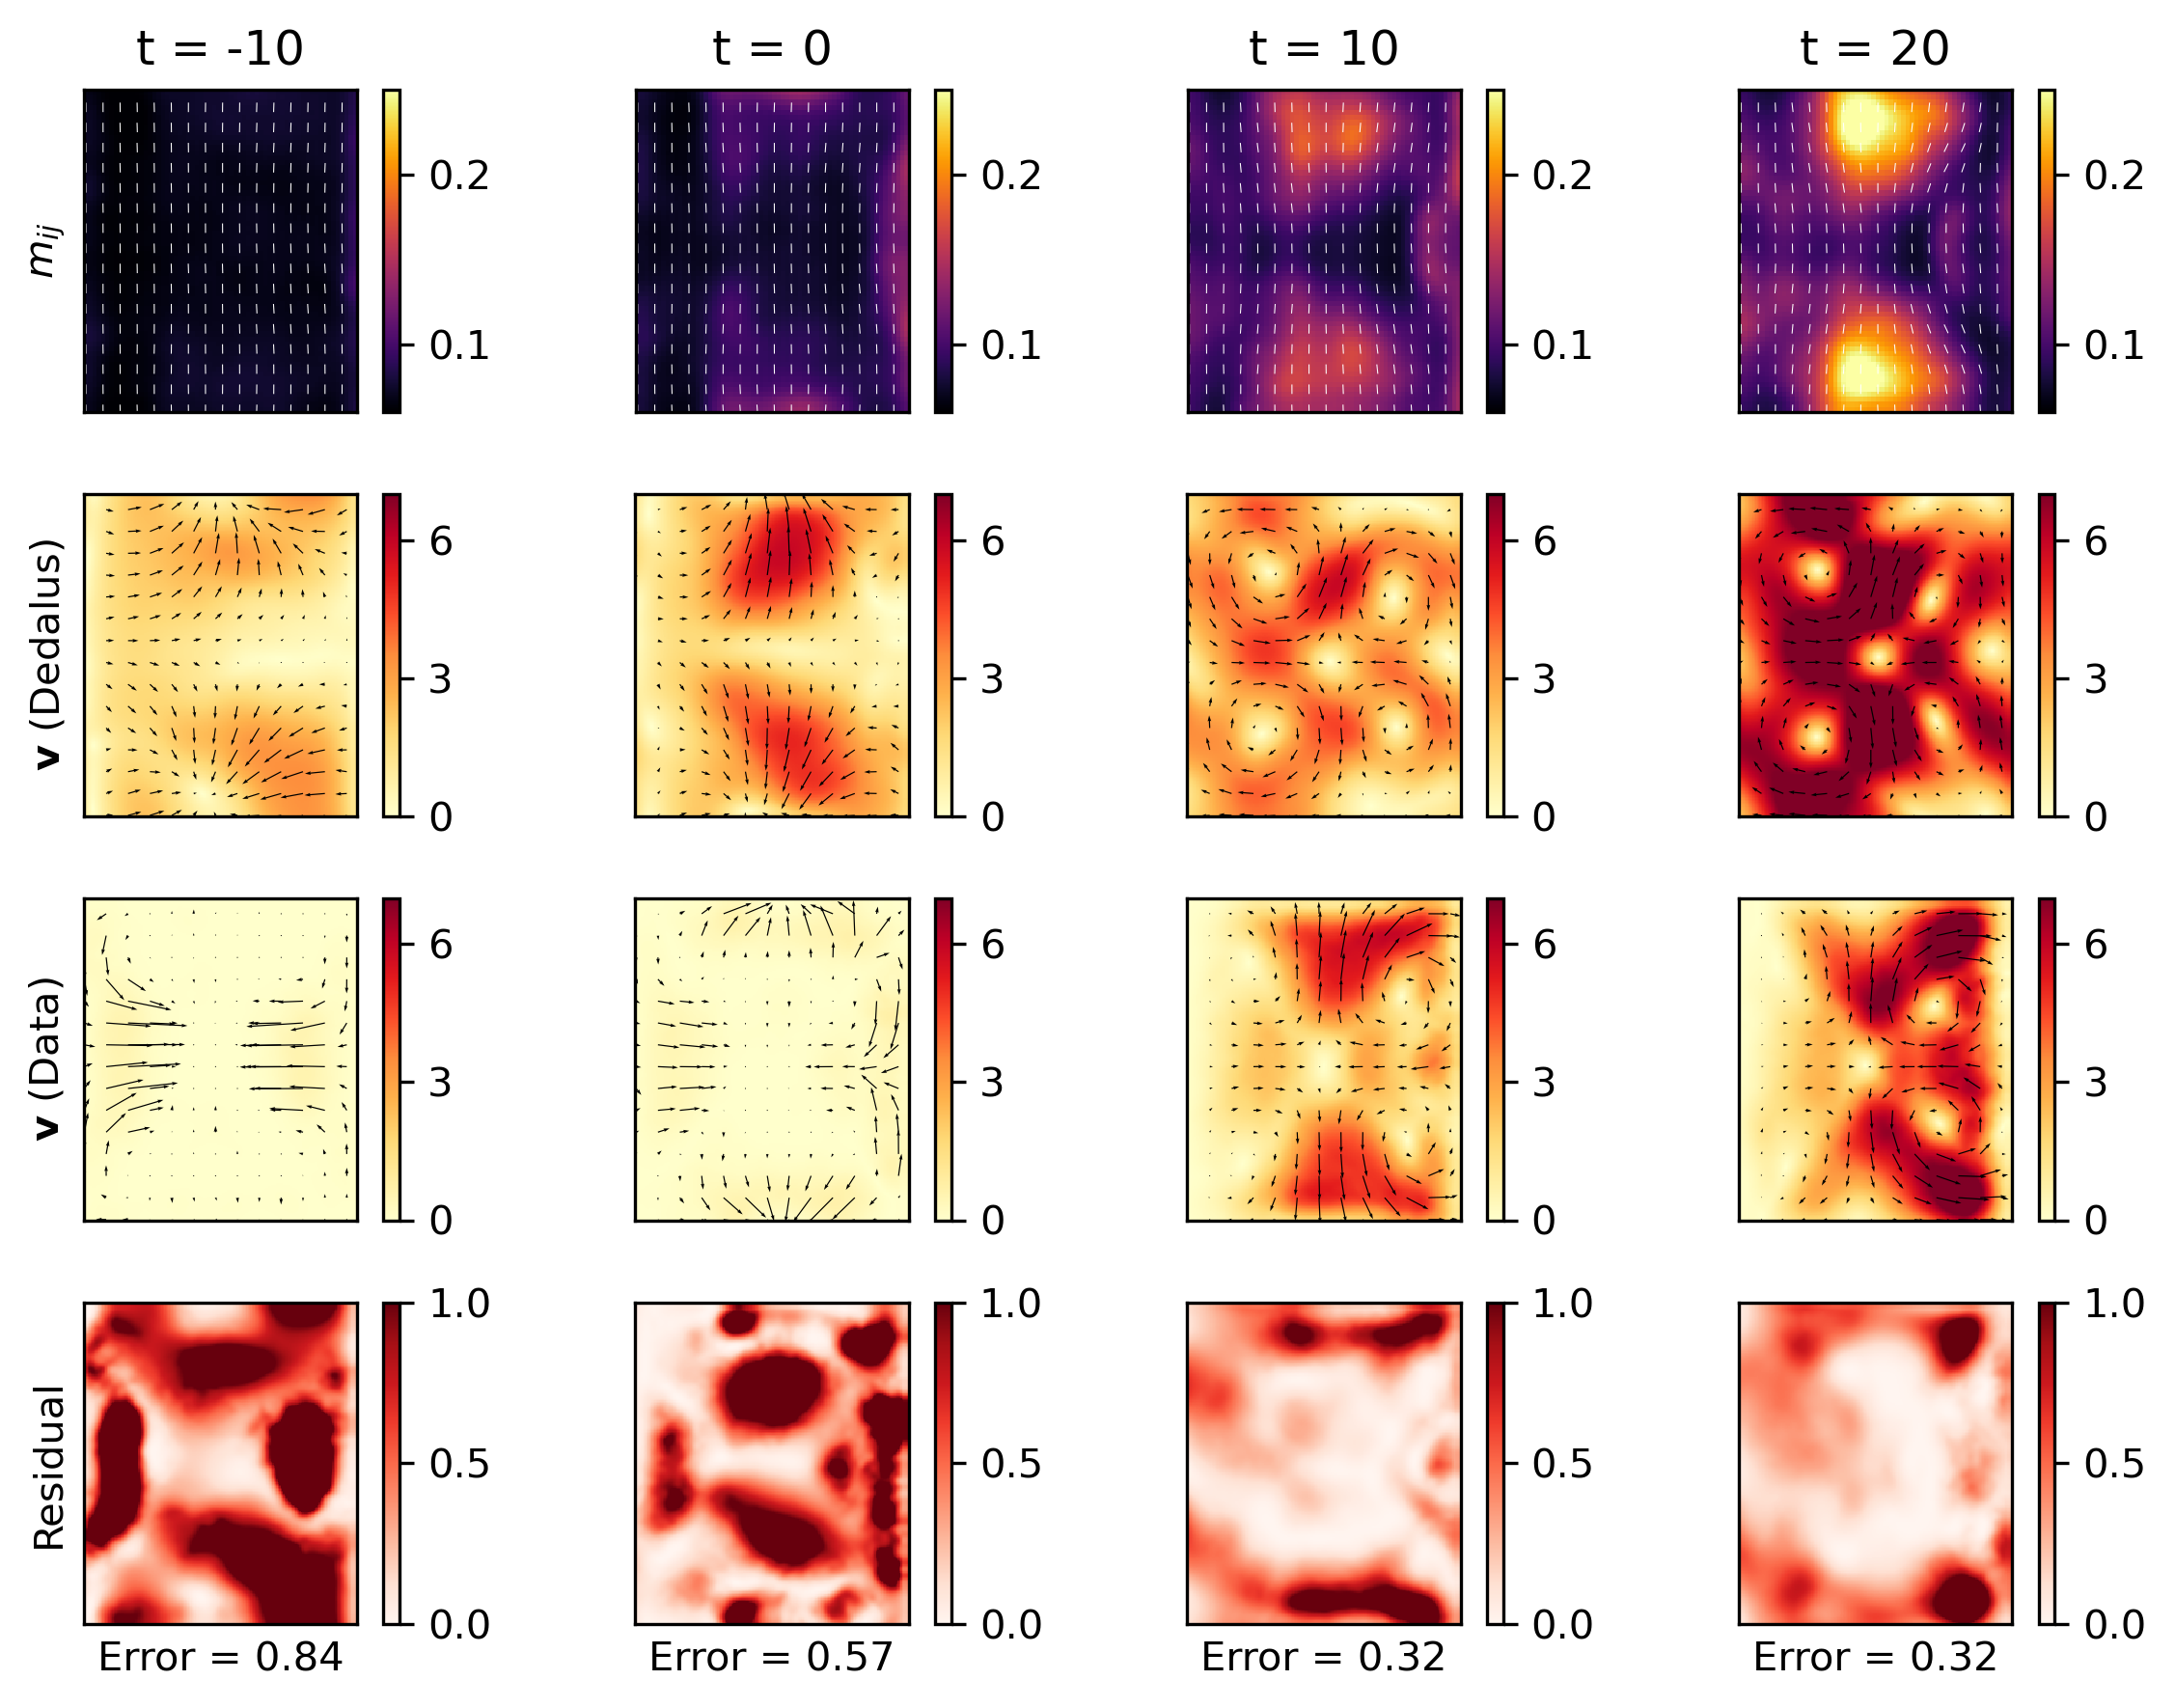

In [110]:
from scipy.interpolate import RectBivariateSpline
folder = '../flydrive/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP/ensemble'
tt = 15
t0 = np.load(f'{folder}/t.npy')
print(f'Initial time = {t0[tt]}')
m0 = np.load(f'{folder}/tensor2D.npy', mmap_mode='r')
v0 = np.load(f'{folder}/velocity2D.npy', mmap_mode='r')

Lx, Ly = 452., 533.
Nx, Ny = 64, 64

dealias = 3/2
mu, α = 1, 8

# Bases
coords = d3.CartesianCoordinates("x", "y")
dist = d3.Distributor(coords, dtype=np.float64)
xbasis = d3.RealFourier(  coords["x"], size=Nx, bounds=(-Lx/2,Lx/2), dealias=dealias)
ybasis = d3.RealFourier(coords["y"], size=Ny, bounds=(-Ly/2,Ly/2), dealias=dealias)
x1, y1 = dist.local_grids(xbasis, ybasis)
x0 = np.linspace(-Lx/2, Lx/2, m0.shape[-1])
y0 = np.linspace(-Ly/2, Ly/2, m0.shape[-2])
x = np.squeeze(xbasis.local_grid(dist, 1))
y = np.squeeze(ybasis.local_grid(dist, 1))

skip = 4
X, Y = np.meshgrid(x.flatten()[::skip], y.flatten()[::skip])
X0, Y0 = np.meshgrid(x0.flatten()[::16], y0.flatten()[::16])


def get_g_with_scales(field, scales):
    f = field.copy()
    f.change_scales(scales)
    return f["g"]

def residual(u, v):
    '''
    We assume u is the INPUT and v is the TARGET
    Using residual metric from Sebastian's eLife paper to track how flow configuration is predicted
    '''
    umag = np.linalg.norm(u, axis=-3)
    vmag = np.linalg.norm(v, axis=-3)

    uavg = np.sqrt(np.mean(umag**2, axis=(-2,-1), keepdims=True))
    vavg = np.sqrt(np.mean(vmag**2, axis=(-2,-1), keepdims=True))

    res = uavg**2 * vmag**2 + vavg**2 * umag**2 - 2 * uavg * vavg * np.einsum('...ijk,...ijk->...jk', u, v)
    denom = 2 * vavg**2 * uavg**2
    denom[denom == 0] += 1
    res /= denom
    return res

times = [0, 10, 20, 30]
fig, ax = plt.subplots(4, len(times), dpi=300, figsize=(len(times)*2, 6))

for i, tt in enumerate([0, 10, 20, 30]):
    # Fields
    v = dist.VectorField(coords, name="v", bases=(xbasis,ybasis))
    m = dist.TensorField(coords, name="m", bases=(xbasis,ybasis))

    #Tau terms
    tau_v = dist.VectorField(coords, name='tau_v') #Residual for velocity

    # Forcing conditions
    m["g"][0,0,:,:] = RectBivariateSpline(x0, y0, m0[tt, 1,1].T)(x, y)
    m["g"][0,1,:,:] = RectBivariateSpline(x0, y0, m0[tt, 0,1].T)(x, y)
    m["g"][1,0,:,:] = m['g'][0,1,:,:]
    m["g"][1, 1,:,:] = RectBivariateSpline(x0, y0, m0[tt, 0, 0].T)(x, y)

    B = 50 * np.tanh((t0[tt] - 5) / 2) + 50
    print(B)

    #Static velocity Problem
    problem = d3.LBVP([v, tau_v], namespace=locals())
    problem.add_equation("mu*lap(v) + B*grad(div(v)) + tau_v = -α * div(m) ") # Stokes equation (with tau residual)
    problem.add_equation("integ(v) = 0") #No net y-flow gauge

    # Solver
    solver = problem.build_solver()
    solver.solve()

    # Extract fields
    vi = get_g_with_scales(v, (1, 1))
    mij = get_g_with_scales(m, (1, 1))

    v1 = np.zeros([2, 236, 200])
    m1 = np.zeros([2, 2, 236, 200])

    v1[1] = RectBivariateSpline(x, y, vi[0])(x0, y0).T
    v1[0] = RectBivariateSpline(x, y, vi[1])(x0, y0).T

    # Plot fields
    mij = mij.transpose(2, 3, 0, 1)
    m = np.linalg.norm(mij, axis=(2, 3))
    el, ev = np.linalg.eigh(mij) #Positive eigenvalue is n
    n = ev[..., 1]

    pcM = ax[0, i].pcolormesh(x, y, m.T, cmap='inferno', vmin=0.06, vmax=0.25)
    ax[0, i].quiver(X, Y, n[::skip, ::skip, 0].T, n[::skip, ::skip, 1].T,
                pivot='middle', color='white',
                headwidth=0, headlength=0, headaxislength=0)

    cb = plt.colorbar(pcM, ax=ax[0,i], ticks=[0.1, 0.2])
  
    pcV = ax[1,i].pcolormesh(x0, y0, np.linalg.norm(v1, axis=0), vmin=0, vmax=7, cmap='YlOrRd')
    ax[1,i].quiver(X0, Y0, v1[1, ::16, ::16], v1[0, ::16, ::16], 
                   color="black")
    cb = plt.colorbar(pcV, ax=ax[1,i], ticks=[0, 3, 6])


    pcV = ax[2,i].pcolormesh(x0, y0, np.linalg.norm(v0[tt], axis=0), vmin=0, vmax=7, cmap='YlOrRd')
    ax[2,i].quiver(X0, Y0, v0[tt, 1, ::16, ::16], v0[tt, 0, ::16, ::16], 
                   color="black")
    cb = plt.colorbar(pcV, ax=ax[2,i], ticks=[0, 3, 6])

    res = residual(v0[tt], v1)
    pcR = ax[3,i].pcolormesh(x0, y0, res, cmap='Reds', vmin=0, vmax=1)
    cb = plt.colorbar(pcR, ax=ax[3,i], ticks=[0, 0.5, 1])
    ax[3, i].set_xlabel(f'Error = {res.mean():.2f}')

    ax[0, i].set_title(f't = {t0[tt]}')

ax[0, 0].set_ylabel(r'$m_{ij}$')
ax[1, 0].set_ylabel(r'$\mathbf{v}$ (Dedalus)')
ax[2, 0].set_ylabel(r'$\mathbf{v}$ (Data)')
ax[3, 0].set_ylabel('Residual')

for a in ax.flatten():
    a.set(aspect='equal', xticks=[], yticks=[])

plt.tight_layout()

# Compressible Stokes equation on topological cylinder

Initial time = 5
3.0590222692694624e-05
0.6692850924284812
99.33071490757152
99.99996940977731


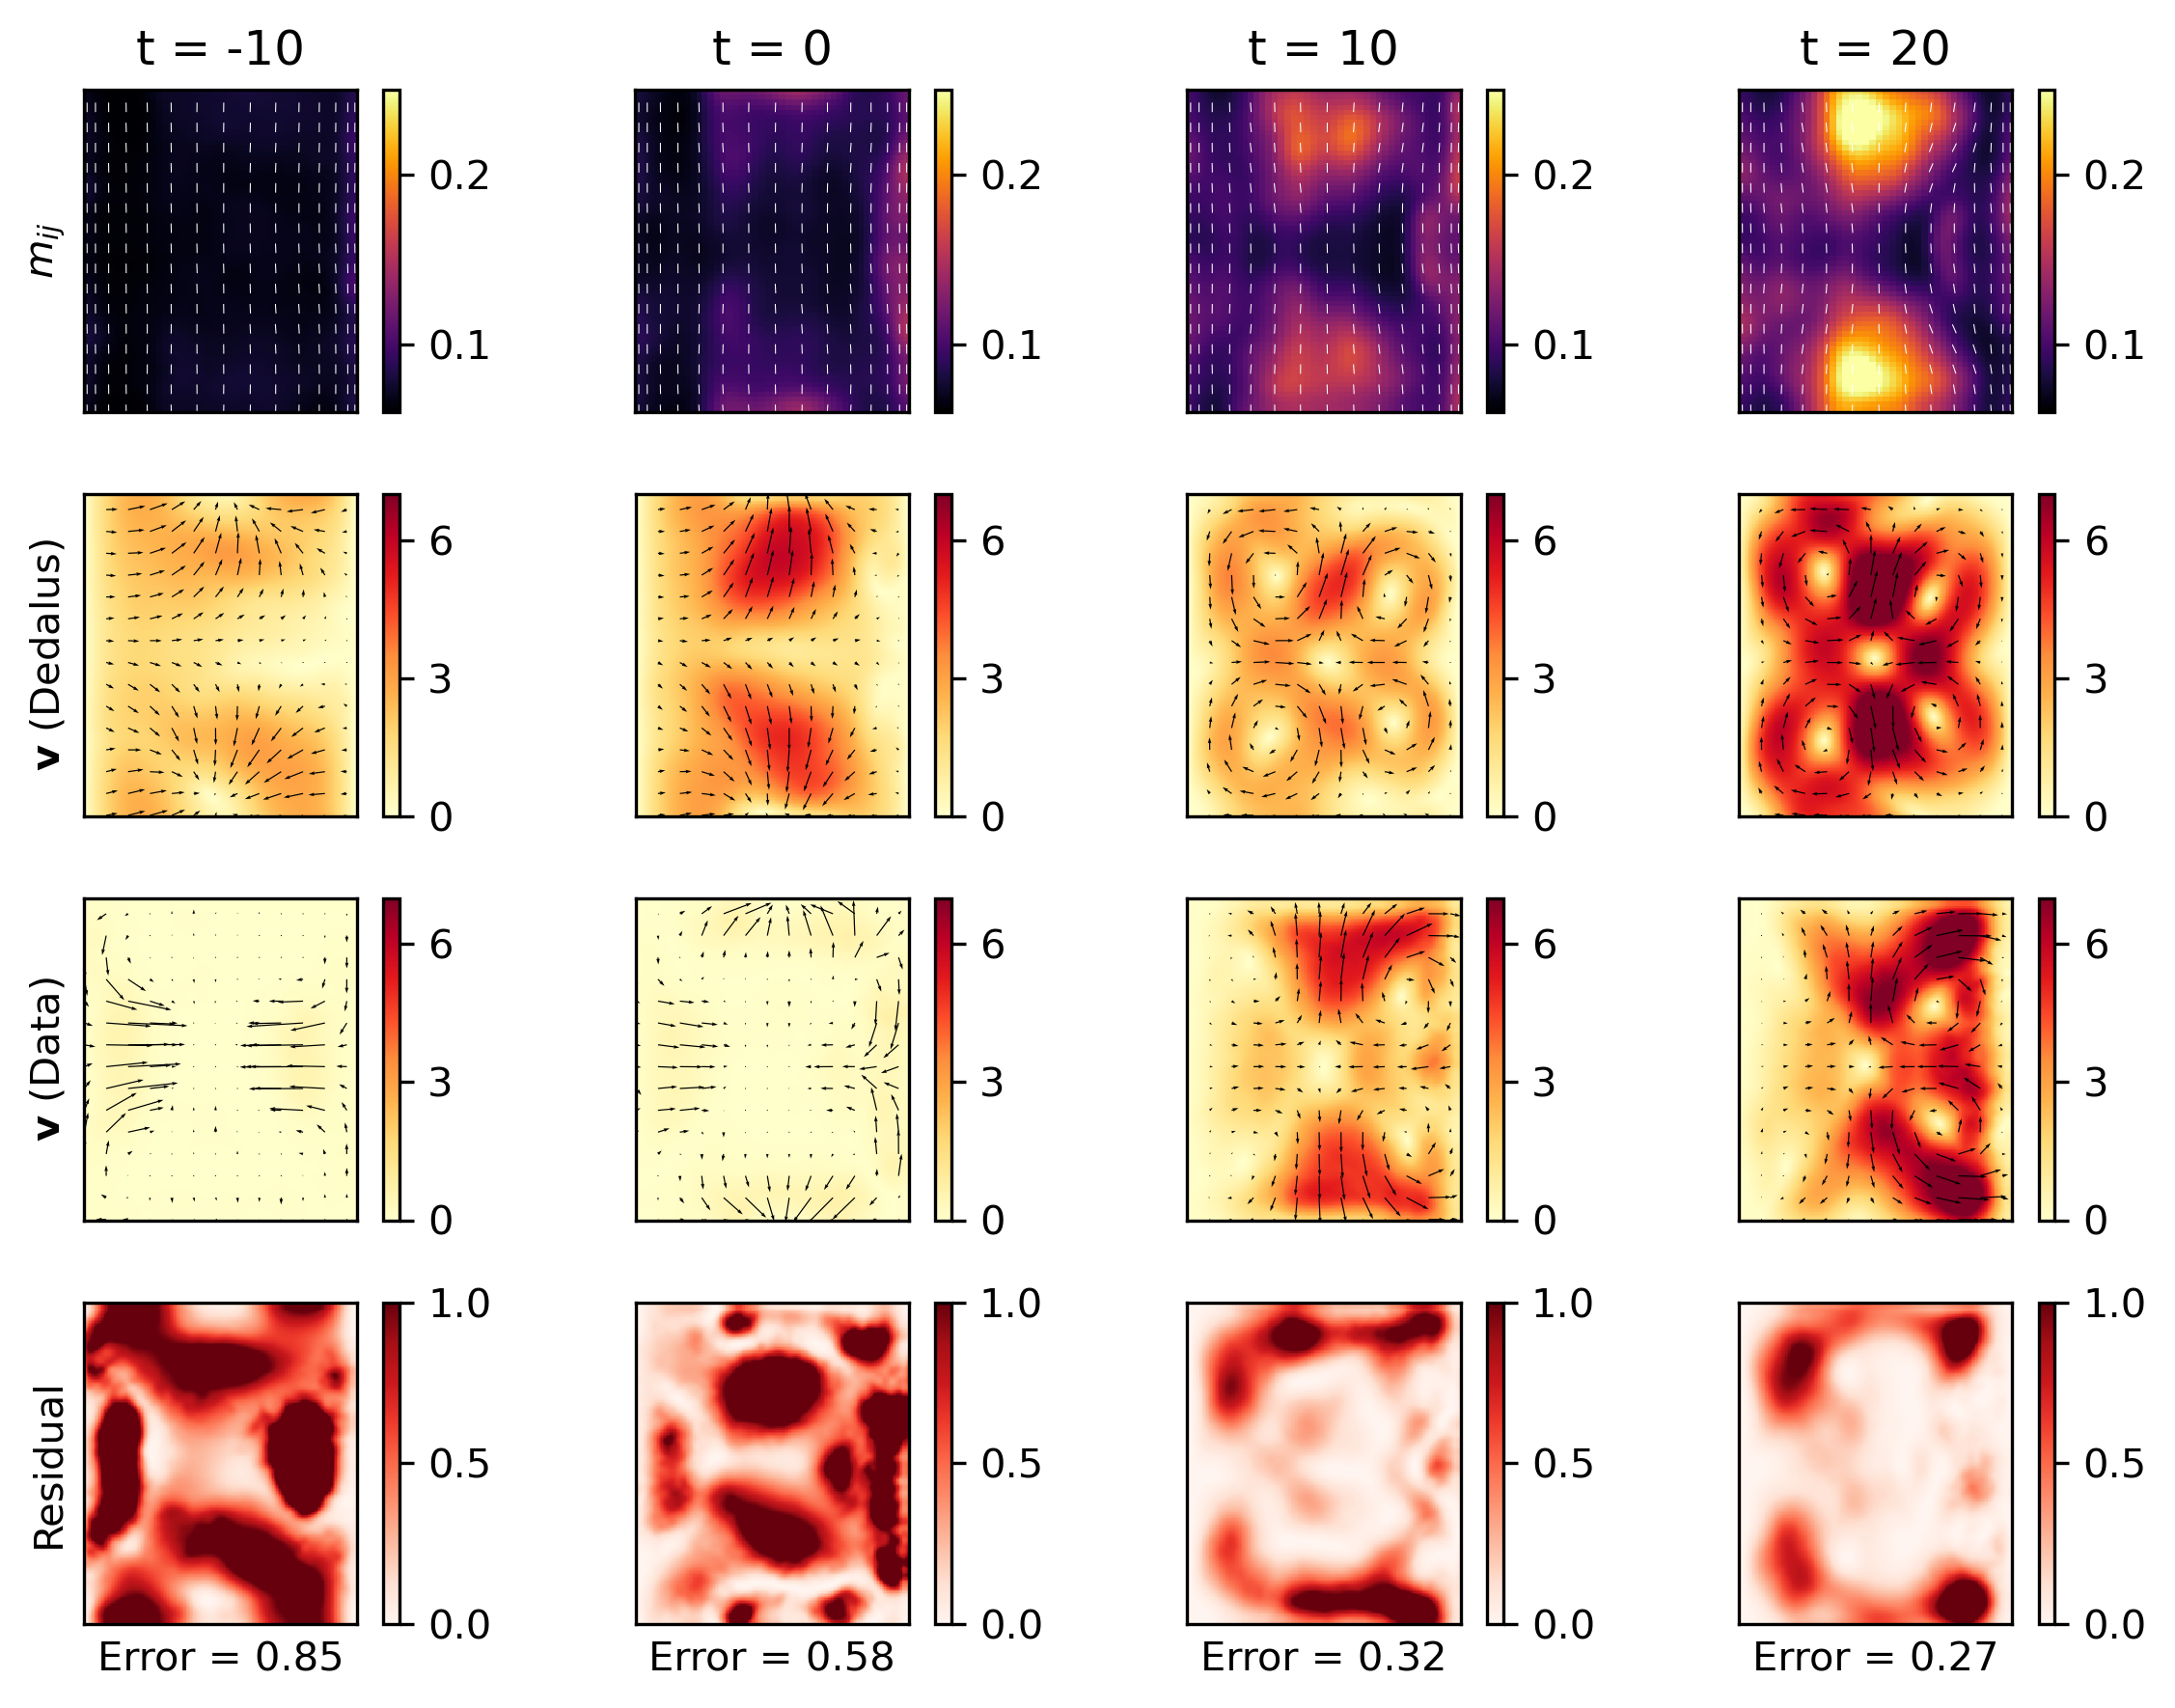

In [120]:
from scipy.interpolate import RectBivariateSpline
folder = '../flydrive/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP/ensemble'
tt = 15
t0 = np.load(f'{folder}/t.npy')
print(f'Initial time = {t0[tt]}')
m0 = np.load(f'{folder}/tensor2D.npy', mmap_mode='r')
v0 = np.load(f'{folder}/velocity2D.npy', mmap_mode='r')

Lx, Ly = 452., 533.
Nx, Ny = 64, 64

dealias = 3/2
mu, α = 1, 8

# Bases
coords = d3.CartesianCoordinates("x", "y")
dist = d3.Distributor(coords, dtype=np.float64)
xbasis = d3.Chebyshev(  coords["x"], size=Nx, bounds=(-Lx/2,Lx/2), dealias=dealias)
ybasis = d3.RealFourier(coords["y"], size=Ny, bounds=(-Ly/2,Ly/2), dealias=dealias)
x1, y1 = dist.local_grids(xbasis, ybasis)
x0 = np.linspace(-Lx/2, Lx/2, m0.shape[-1])
y0 = np.linspace(-Ly/2, Ly/2, m0.shape[-2])
x = np.squeeze(xbasis.local_grid(dist, 1))
y = np.squeeze(ybasis.local_grid(dist, 1))

skip = 4
X, Y = np.meshgrid(x.flatten()[::skip], y.flatten()[::skip])
X0, Y0 = np.meshgrid(x0.flatten()[::16], y0.flatten()[::16])


def get_g_with_scales(field, scales):
    f = field.copy()
    f.change_scales(scales)
    return f["g"]

def residual(u, v):
    '''
    We assume u is the INPUT and v is the TARGET
    Using residual metric from Sebastian's eLife paper to track how flow configuration is predicted
    '''
    umag = np.linalg.norm(u, axis=-3)
    vmag = np.linalg.norm(v, axis=-3)

    uavg = np.sqrt(np.mean(umag**2, axis=(-2,-1), keepdims=True))
    vavg = np.sqrt(np.mean(vmag**2, axis=(-2,-1), keepdims=True))

    res = uavg**2 * vmag**2 + vavg**2 * umag**2 - 2 * uavg * vavg * np.einsum('...ijk,...ijk->...jk', u, v)
    denom = 2 * vavg**2 * uavg**2
    denom[denom == 0] += 1
    res /= denom
    return res

times = [0, 10, 20, 30]
fig, ax = plt.subplots(4, len(times), dpi=300, figsize=(len(times)*2, 6))

for i, tt in enumerate([0, 10, 20, 30]):
    # Fields
    v = dist.VectorField(coords, name="v", bases=(xbasis,ybasis))
    m = dist.TensorField(coords, name="m", bases=(xbasis,ybasis))

    #Tau terms
    tau_vy = dist.Field(name='tau_v') #Residual for y-component of velocity
    tau_v1 = dist.VectorField(coords, name='tau_v1', bases=ybasis)
    tau_v2 = dist.VectorField(coords, name='tau_v2', bases=ybasis)

    # Forcing conditions
    m["g"][0,0,:,:] = RectBivariateSpline(x0, y0, m0[tt, 1,1].T)(x, y)
    m["g"][0,1,:,:] = RectBivariateSpline(x0, y0, m0[tt, 0,1].T)(x, y)
    m["g"][1,0,:,:] = m['g'][0,1,:,:]
    m["g"][1, 1,:,:] = RectBivariateSpline(x0, y0, m0[tt, 0, 0].T)(x, y)

    B = 50 * np.tanh((t0[tt] - 5) / 2) + 50
    print(B)

    #Substitutions
    ex, ey = coords.unit_vector_fields(dist)
    lift_basis = xbasis.derivative_basis(1)
    lift = lambda A: d3.Lift(A, lift_basis, -1)
    grad_v = d3.grad(v) - ex*lift(tau_v1)

    #Static velocity Problem
    problem = d3.LBVP([v, tau_vy, tau_v1, tau_v2], namespace=locals())
    problem.add_equation("mu*div(grad_v) + B*grad(div(v)) + lift(tau_v2) + tau_vy*ey = -α * div(m) ") # Stokes equation (with tau residual)
    #problem.add_equation("mu*div(grad_v) + lift(tau_v2) + tau_vy*ey = -α * div(m) - B*grad(div(v))")
    problem.add_equation("integ(v @ ey) = 0") #No net y-flow gauge

    #Boundary conditions
    problem.add_equation("v(x=-Lx/2) = 0") #Dirichlet BC 
    problem.add_equation("v(x=+Lx/2) = 0") #Dirichlet BC

    # Solver
    solver = problem.build_solver()
    solver.solve()

    # Extract fields
    vi = get_g_with_scales(v, (1, 1))
    mij = get_g_with_scales(m, (1, 1))

    v1 = np.zeros([2, 236, 200])
    m1 = np.zeros([2, 2, 236, 200])

    v1[1] = RectBivariateSpline(x, y, vi[0])(x0, y0).T
    v1[0] = RectBivariateSpline(x, y, vi[1])(x0, y0).T

    # Plot fields
    mij = mij.transpose(2, 3, 0, 1)
    m = np.linalg.norm(mij, axis=(2, 3))
    el, ev = np.linalg.eigh(mij) #Positive eigenvalue is n
    n = ev[..., 1]

    pcM = ax[0, i].pcolormesh(x, y, m.T, cmap='inferno', vmin=0.06, vmax=0.25)
    ax[0, i].quiver(X, Y, n[::skip, ::skip, 0].T, n[::skip, ::skip, 1].T,
                pivot='middle', color='white',
                headwidth=0, headlength=0, headaxislength=0)

    cb = plt.colorbar(pcM, ax=ax[0,i], ticks=[0.1, 0.2])
  
    pcV = ax[1,i].pcolormesh(x0, y0, np.linalg.norm(v1, axis=0), vmin=0, vmax=7, cmap='YlOrRd')
    ax[1,i].quiver(X0, Y0, v1[1, ::16, ::16], v1[0, ::16, ::16], 
                   color="black")
    cb = plt.colorbar(pcV, ax=ax[1,i], ticks=[0, 3, 6])


    pcV = ax[2,i].pcolormesh(x0, y0, np.linalg.norm(v0[tt], axis=0), vmin=0, vmax=7, cmap='YlOrRd')
    ax[2,i].quiver(X0, Y0, v0[tt, 1, ::16, ::16], v0[tt, 0, ::16, ::16], 
                   color="black")
    cb = plt.colorbar(pcV, ax=ax[2,i], ticks=[0, 3, 6])

    res = residual(v0[tt], v1)
    pcR = ax[3,i].pcolormesh(x0, y0, res, cmap='Reds', vmin=0, vmax=1)
    cb = plt.colorbar(pcR, ax=ax[3,i], ticks=[0, 0.5, 1])
    ax[3, i].set_xlabel(f'Error = {res.mean():.2f}')

    ax[0, i].set_title(f't = {t0[tt]}')


ax[0, 0].set_ylabel(r'$m_{ij}$')
ax[1, 0].set_ylabel(r'$\mathbf{v}$ (Dedalus)')
ax[2, 0].set_ylabel(r'$\mathbf{v}$ (Data)')
ax[3, 0].set_ylabel('Residual')

for a in ax.flatten():
    a.set(aspect='equal', xticks=[], yticks=[])

plt.tight_layout()